In [7]:
"""
# 📉 Baseline Model: Logistic Regression + TF-IDF on News Source Names
AI Course - NLP Track  
This notebook implements a simple classification model to predict the political stance 
of a news engagement based on the news source mentioned.
"""

'\n# 📉 Baseline Model: Logistic Regression + TF-IDF on News Source Names\nAI Course - NLP Track  \nThis notebook implements a simple classification model to predict the political stance \nof a news engagement based on the news source mentioned.\n'

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
# -------------------- 1. Load Data with Random Sampling --------------------
DATA_PATH = "../data/icwsm-2024-forecasting-data-anon.json"
SAMPLE_FRACTION = 0.05  # 5% of total data (reduced for faster execution)
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
print(f"📂 Loading {SAMPLE_FRACTION*100:.0f}% random sample from {DATA_PATH}...")

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f"📊 Total records in full dataset: {len(raw_data):,}")
print(f"🎯 Random sampling: {SAMPLE_FRACTION*100:.0f}%")


📂 Loading 5% random sample from ../data/icwsm-2024-forecasting-data-anon.json...
📊 Total records in full dataset: 5,637,781
🎯 Random sampling: 5%


In [4]:
# Random sampling of keys
all_keys = list(raw_data.keys())
sampled_keys = random.sample(all_keys, int(len(all_keys) * SAMPLE_FRACTION))

records = []
for key in tqdm(sampled_keys, desc="Loading records"):
    value = raw_data[key]
    user_id = value['user_id_anonymized']
    timestamp = value['created_at']
    sources = value['news sources']
    stances = value['partisan stance']
    
    # Create one record per news source (a tweet may contain multiple sources)
    for src, st in zip(sources, stances):
        records.append({
            'user_id': user_id,
            'timestamp': timestamp,
            'source': src,
            'stance': st
        })

df = pd.DataFrame(records)
print(f"\n✅ Total records (one per source): {len(df):,}")
print(f"✅ Unique news sources: {df['source'].nunique():,}")
print(f"✅ Stance distribution:")
print(df['stance'].value_counts().sort_index())

Loading records: 100%|██████████| 281889/281889 [00:04<00:00, 66256.62it/s] 



✅ Total records (one per source): 290,145
✅ Unique news sources: 494
✅ Stance distribution:
stance
-3.0     4330
-2.0    53615
-1.0    91803
 0.0    55026
 1.0    23617
 2.0    54286
 3.0     7468
Name: count, dtype: int64


In [5]:
# -------------------- 2. Feature Engineering & Label Encoding --------------------
# TF-IDF vectorization on news source names
vectorizer = TfidfVectorizer(
    max_features=1000, 
    lowercase=True, 
    analyzer='word', 
    stop_words='english'
)
X = vectorizer.fit_transform(df['source'])

# Encode stances (from -3,-2,-1,0,1,2,3 to 0-6)
le = LabelEncoder()
y = le.fit_transform(df['stance'])

print(f"\n📐 Feature matrix shape: {X.shape}")
print(f"🏷️ Classes: {le.classes_}")


📐 Feature matrix shape: (290145, 591)
🏷️ Classes: [-3. -2. -1.  0.  1.  2.  3.]


In [6]:
# -------------------- 3. Train/Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"\n📊 Training set size: {X_train.shape[0]:,}")
print(f"📊 Test set size: {X_test.shape[0]:,}")


📊 Training set size: 232,116
📊 Test set size: 58,029


In [9]:
# -------------------- 4. Train Logistic Regression Model --------------------
model = LogisticRegression(
    max_iter=1000, 
    random_state=RANDOM_SEED,
    solver='lbfgs'
)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [10]:
# -------------------- 5. Model Evaluation --------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("📊 MODEL PERFORMANCE")
print("="*60)
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ F1-Score (macro):   {f1_macro:.4f}")
print(f"✅ F1-Score (weighted): {f1_weighted:.4f}")


📊 MODEL PERFORMANCE
✅ Accuracy:  0.9870
✅ F1-Score (macro):   0.9844
✅ F1-Score (weighted): 0.9866


In [11]:
# -------------------- 6. Classification Report --------------------
print("\n📋 Classification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=[f'Stance {c}' for c in le.classes_]
))



📋 Classification Report:
              precision    recall  f1-score   support

 Stance -3.0       1.00      1.00      1.00       866
 Stance -2.0       1.00      1.00      1.00     10723
 Stance -1.0       0.96      1.00      0.98     18361
  Stance 0.0       1.00      1.00      1.00     11005
  Stance 1.0       1.00      0.84      0.92      4723
  Stance 2.0       1.00      1.00      1.00     10857
  Stance 3.0       1.00      0.99      1.00      1494

    accuracy                           0.99     58029
   macro avg       0.99      0.98      0.98     58029
weighted avg       0.99      0.99      0.99     58029



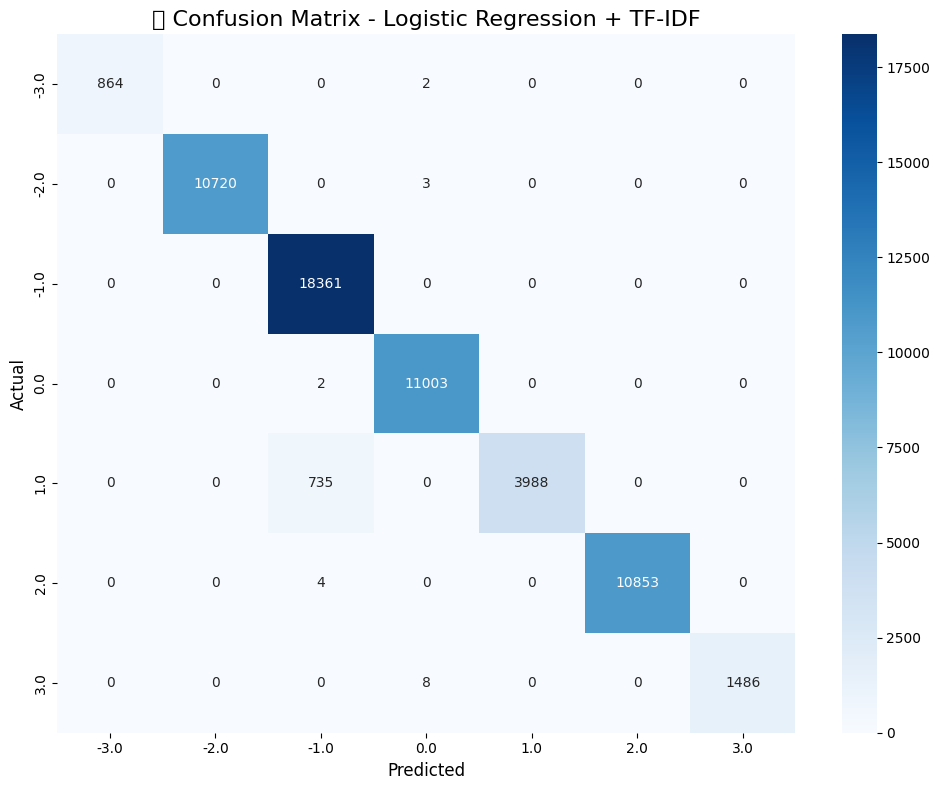

In [12]:
# -------------------- 7. Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[f'{c}' for c in le.classes_],
    yticklabels=[f'{c}' for c in le.classes_]
)
plt.title('🔲 Confusion Matrix - Logistic Regression + TF-IDF', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()


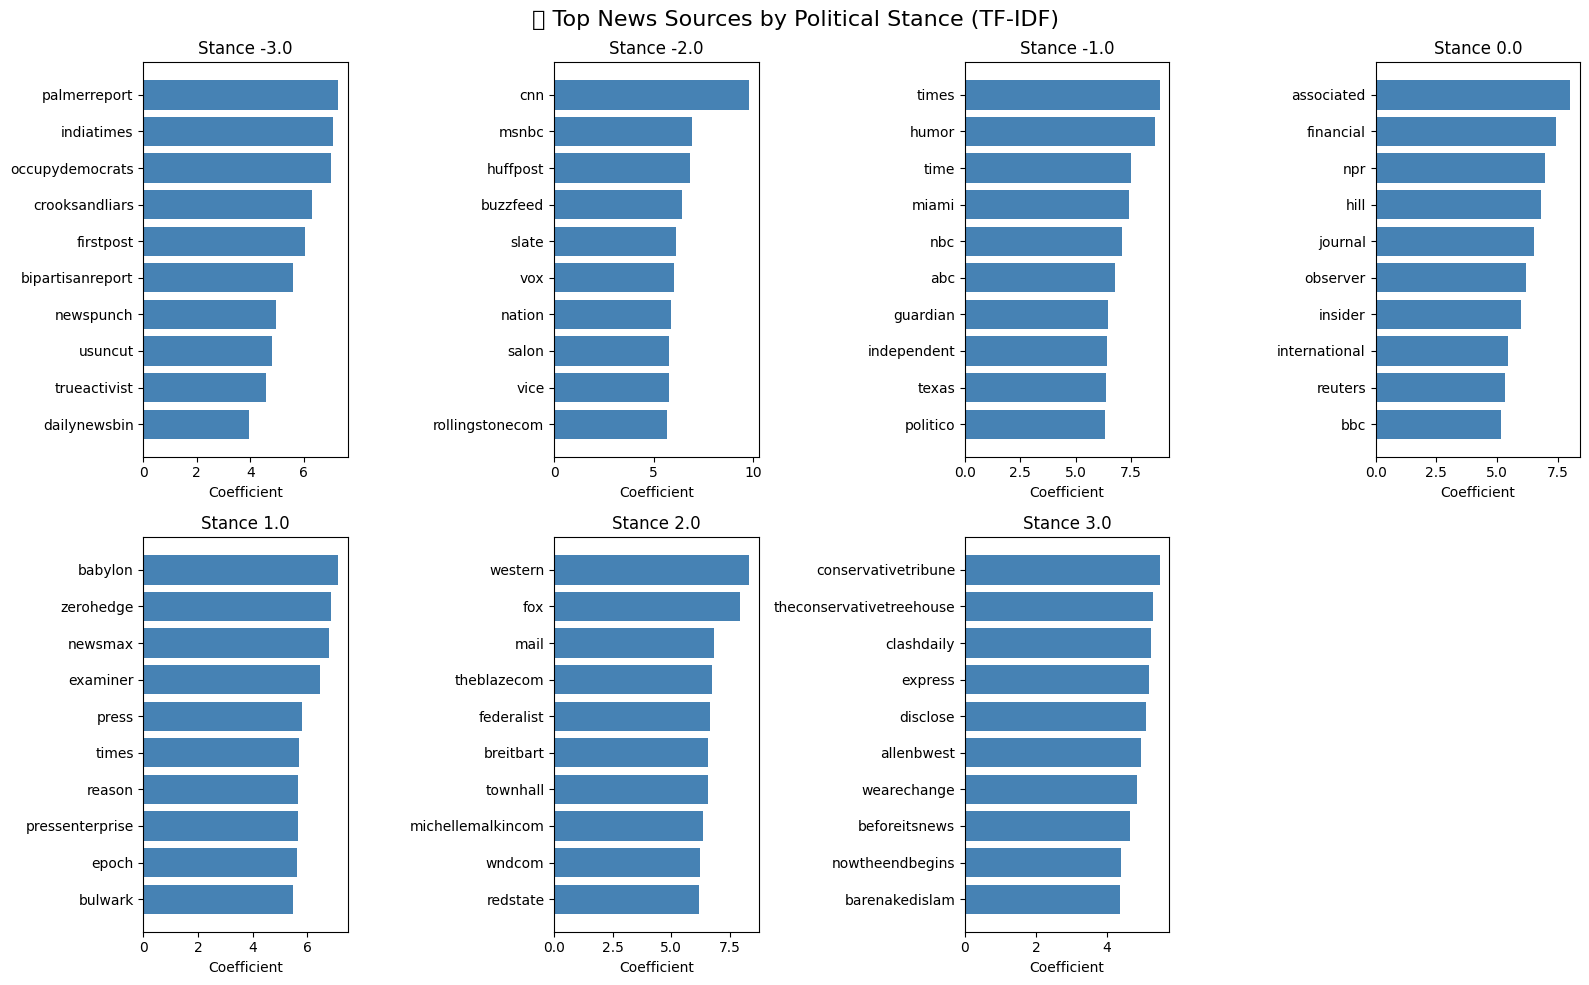

In [13]:
# -------------------- 8. Top Features per Class --------------------
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_
n_top = 10  # Top 10 features per class

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.ravel()

for i, class_label in enumerate(le.classes_):
    if i >= len(axes):
        break
    
    # Get top positive coefficients for this class
    top_indices = np.argsort(coef[i])[-n_top:]
    top_features = [feature_names[idx] for idx in top_indices]
    top_scores = coef[i][top_indices]
    
    # Horizontal bar plot
    axes[i].barh(range(n_top), top_scores, color='steelblue')
    axes[i].set_yticks(range(n_top))
    axes[i].set_yticklabels(top_features)
    axes[i].set_title(f'Stance {class_label}')
    axes[i].set_xlabel('Coefficient')

# Hide unused subplot
if len(le.classes_) < 8:
    axes[-1].axis('off')

plt.suptitle('🔝 Top News Sources by Political Stance (TF-IDF)', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
print("\n✅ Baseline model completed successfully.")


✅ Baseline model completed successfully.
